(512, 512) 0.972549


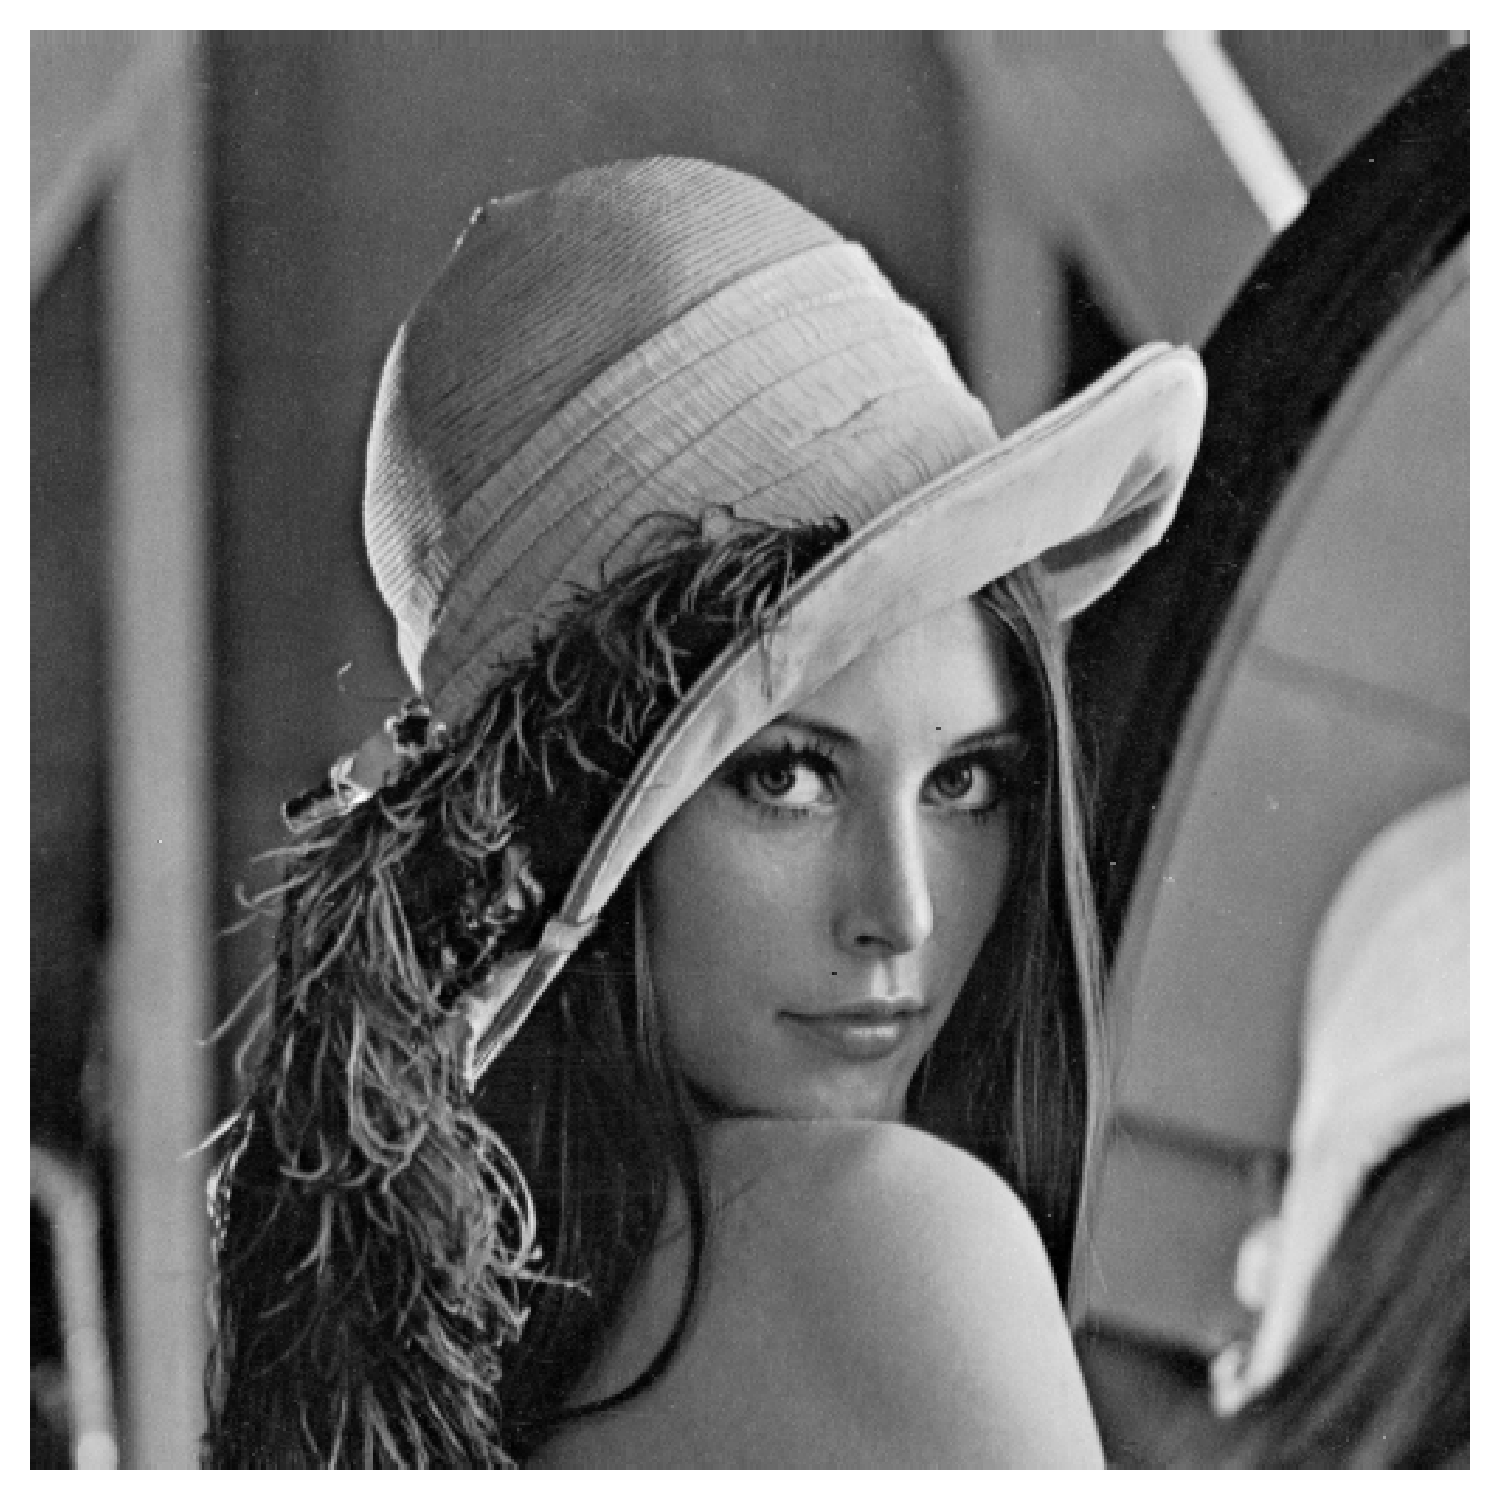

In [31]:
# Libraries + data loading

import numpy as np
import torch
import math
import time
from skimage import io, filters, color
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, ifftshift
from scipy.signal import correlate, convolve2d
from skimage import data, io
import cv2


pi=np.pi
atan2=math.atan2
np.int=int
sin=np.sin
cos=np.cos
fft=np.fft.fft
fft2=np.fft.fft2
ifft2=np.fft.ifft2
fftshift=np.fft.fftshift
ifftshift=np.fft.ifftshift

log=np.log
real=np.real
conj=np.conj
atan2=math.atan2
tan=np.tan
fftshift=np.fft.fftshift


path = Path.cwd()   # répertoire courant (là où tourne ton notebook) 

image_name = 'lena'
image_format = 'tif'

def load_data(img_name, img_format):
    image_path = path / "images" / f"{img_name}.{img_format}"
    image = io.imread(image_path)
    return image

image = load_data(image_name,image_format)  
# image = data.astronaut()  # Example image from skimage



def view_image(img, dpi=300, cmap='gray'):
    fig = plt.figure(dpi=dpi)
    ax = plt.axes([0, 0, 1, 1])  # occupe 100% de la figure
    ax.imshow(img, cmap=cmap, interpolation='nearest')  # évite les halos
    ax.axis('off')
    plt.show()


def to_gray(img):
    img = np.asarray(img, dtype=np.float32)

    if img.ndim == 2:  
        gray = img
    elif img.ndim == 3:
        if img.shape[2] == 4:  
            img = img[..., :3]
        if img.shape[2] == 3:
            gray = 0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]
        else:
            raise ValueError("Format d'image non supporté")
    else:
        raise ValueError("Format d'image non supporté")

    if gray.max() > 1.0:
        gray /= 255.0

    return gray.astype(np.float32)


import numpy as np

def crop_white(img, tol=1e-3):
    mask = img < (1 - tol)
    if not mask.any():
        return img
    y, x = np.where(mask)
    return img[y.min():y.max()+1, x.min():x.max()+1]


image = to_gray(image)  
image = crop_white(image)
print(image.shape, image.max())
view_image(image)  



In [60]:

def grad_half_sample(u):
    u = u.astype(np.float32, copy=False)
    gx = np.zeros_like(u, dtype=np.float32)
    gy = np.zeros_like(u, dtype=np.float32)
    gx[:, :-1] = u[:, 1:] - u[:, :-1]
    gx[:, -1] = 0.0
    gy[:-1, :] = u[1:, :] - u[:-1, :]
    gy[-1, :] = 0.0
    return gx, gy

def div_half_sample(px, py):
    px = px.astype(np.float32, copy=False)
    py = py.astype(np.float32, copy=False)

    dx = np.zeros_like(px, dtype=np.float32)
    dy = np.zeros_like(py, dtype=np.float32)

    # Adjoint du gradient "forward + zéro au bord"
    dx[:, 0]      =  px[:, 0]
    dx[:, 1:-1]   =  px[:, 1:-1] - px[:, :-2]
    dx[:, -1]     = -px[:, -2]

    dy[0, :]      =  py[0, :]
    dy[1:-1, :]   =  py[1:-1, :] - py[:-2, :]
    dy[-1, :]     = -py[-2, :]

    return dx + dy

def shrink_iso(u, b, gamma):
    gx, gy = grad_half_sample(u)
    vx, vy = gx + b[0], gy + b[1]
    mag = np.sqrt(vx*vx + vy*vy) + 1e-12
    s = np.maximum(1.0 - 1.0/(gamma*mag), 0.0)      
    return s * vx, s * vy

def extend_sym(u):
    """Extension miroir 2H×2W (half-sample)."""
    H, W = u.shape
    u_y  = np.concatenate([u, u[::-1, :]], axis=0)
    u_xy = np.concatenate([u_y, u_y[:, ::-1]], axis=1)
    return u_xy[:2*H, :2*W].astype(np.float32, copy=False)

def inv_extend_sym(u):
    H2, W2 = u.shape
    H, W = H2//2, W2//2
    return u[:H, :W].astype(np.float32, copy=False)

def center_kernel_on_grid(H2, W2, k):
    """Place k au centre (H2,W2) puis ifftshift pour convolution FFT correcte."""
    k = np.asarray(k, dtype=np.float32)
    KH, KW = k.shape
    canvas = np.zeros((H2, W2), dtype=np.float32)
    i0, j0 = (H2 - KH)//2, (W2 - KW)//2
    canvas[i0:i0+KH, j0:j0+KW] = k
    return ifftshift(canvas)

def normalize_psf(phi):
    phi = np.asarray(phi, dtype=np.float32)
    s = float(phi.sum())
    if s <= 0: raise ValueError("La PSF doit avoir une somme positive.")
    return phi / s

def d_prob(u, b, gamma):
    return shrink_iso(u, b, gamma)

def u_prob(f, phi, lam, gamma, d, b):
    f   = np.asarray(f,   dtype=np.float32)
    phi = normalize_psf(phi)

    H, W   = f.shape
    H2, W2 = 2*H, 2*W
    lam_over_gamma = float(lam) / float(gamma)

    # FFT de la PSF centrée
    PHI  = center_kernel_on_grid(H2, W2, phi)
    Fphi = fft2(PHI)
    Fphi_abs2 = (Fphi.conj() * Fphi).real

    # -Δ (Laplacien positif) -> terme de TV en fréquence
    lap_pos = np.array([[0, -1, 0],
                        [-1, 4, -1],
                        [0, -1, 0]], dtype=np.float32)
    LAP    = center_kernel_on_grid(H2, W2, lap_pos)
    FDelta = fft2(LAP).real

    # FFT des données et du terme de divergence
    FEf = fft2(extend_sym(f))
    div_db = div_half_sample(d[0] - b[0], d[1] - b[1]).astype(np.float32)
    FEdiv = fft2(extend_sym(div_db))  # div(d - b)

    # Système linéaire (ADMM) : ((λ/γ) H*H + (-Δ)) u = (λ/γ) H* f + div(d-b)
    num = lam_over_gamma * (Fphi.conj() * FEf) + FEdiv   # <<< le + est crucial
    den = lam_over_gamma * Fphi_abs2 + FDelta
    den = np.maximum(den, 1e-6)  # éviter division par 0

    Eu = ifft2(num / den).real.astype(np.float32)
    u  = Eu[:H, :W]
    return u

def b_prob(u, d, b):
    gx, gy = grad_half_sample(u)
    return (b[0] + (gx - d[0]), b[1] + (gy - d[1]))

def tv_deconv(f, phi, lam=0.1, gamma=50.0, max_iters=140, tol=None, clip=True):
    """
    Déconvolution TV avec condition de bords symétriques.
    """
    f = np.asarray(f, dtype=np.float32)
    H, W = f.shape

    u = np.zeros((H, W), dtype=np.float32)
    d = (np.zeros_like(u), np.zeros_like(u))
    b = (np.zeros_like(u), np.zeros_like(u))

    if tol is None:
        tol = np.linalg.norm(f.ravel(), 2) / 5000.0

    for _ in range(max_iters):
        u_prev = u

        d = d_prob(u_prev, b, gamma)          
        u = u_prob(f, phi, lam, gamma, d, b)   
        if clip:
            u = np.clip(u, 0.0, 1.0)
        b = b_prob(u, d, b)                   

        if np.linalg.norm((u - u_prev).ravel(), 2) <= tol:
            break

    return u

In [ ]:
#%% FONCTIONS POUR LA DECONVOLUTION TV


def pad_image(im,pad=10):
    out=np.zeros((im.shape[0]+2*pad,im.shape[1]+2*pad))
    out[pad:-pad,pad:-pad]=im
    for k in range(pad):
        out[k,pad:-pad]=im[0,:]
        out[-k-1,pad:-pad]=im[-1,:]
        out[pad:-pad,k]=im[:,0]
        out[pad:-pad,-k-1]=im[:,-1]
    out[:pad,:pad]=im[0,0]
    out[-pad:,:pad]=im[-1,0]
    out[:pad,-pad:]=im[0,-1]
    out[-pad:,-pad:]=im[-1,-1]
    return out

def unpad_image(im,pad=10):
    return im[pad:-pad,pad:-pad].copy()

def Fourier_kernel(K,s):
    assert K.shape[0]%2==1 and K.shape[1]%2==1, "Taille de noyau non impaire"
    Kf=np.zeros(s)
    Ky,Kx=K.shape
    Kx2=Kx//2
    Ky2=Ky//2
    Kf[:Ky2+1,:Kx2+1]=K[Ky2:,Kx2:]
    Kf[:Ky2+1,-Kx2:]=K[Ky2:,:Kx2]
    Kf[-Ky2:,:Kx2+1]=K[:Ky2,Kx2:]
    Kf[-Ky2:,-Kx2:]=K[:Ky2,:Kx2]
    return fft2(Kf)

def taper_image(I,K):
    """ Floute une image I par le noyau K (circulairement) cela donne une image J
    On mélange l'image I avec l'image J de manière à ce que J soit prépondérente aux bords.
    L'image J, lorsqu'on la déconle par le noyau K n'aura pas d'effets de bord. """
    kh,kw=K.shape
    Ih,Iw=I.shape
    wx=np.ones((Ih,Iw),dtype=np.float32)
    wy=np.ones((Ih,Iw),dtype=np.float32)
    X,Y=np.meshgrid(np.arange(0,Iw),np.arange(0,Ih))
    wy[:kh,:]=sin(Y[:kh,:]*pi/(2*kh-1))**2
    wy[-kh:,:]=sin((Ih-Y[-kh:,:])*pi/(2*kh-1))**2
    wx[:,:kw]=sin(X[:,:kw]*pi/(2*kh-1))**2
    wx[:,-kw:]=sin((Iw-X[:,-kw:])*pi/(2*kh-1))**2
    fK=Fourier_kernel(K,I.shape)
    J=real(ifft2(fft2(I)*fK))
    out=J*(1-wx*wy)+I*(wx*wy)
    return out

def conv(im,K,Fourierform=False):
    if not Fourierform:#on recoit les formes spatiales
        Kf=Fourier_kernel(K,im.shape)
        imf=fft2(im)
        return np.real(ifft2(imf*Kf))
    else:# forme Fourier
        return np.real(ifft2(im*K))

def champ_grad(u):#gradient circulaire
    return np.stack((np.c_[(u[:,0]-u[:,-1]).reshape(-1,1),u[:,1:]-u[:,:-1]],\
             np.r_[(u[0,:]-u[-1,:]).reshape(1,-1),u[1:,:]-u[:-1,:]]))

def universal_dot(X,Y):
    return (X*Y).sum()

def div_champ(c):
    return np.c_[c[0,:,1:]-c[0,:,:-1],(c[0,:,0]-c[0,:,-1]).reshape(-1,1)]+\
            np.r_[c[1,1:,:]-c[1,:-1,:],(c[1,0,:]-c[1,-1,:]).reshape(1,-1)]




def d_sub_problem(u,b,gamma=5/255):
    gradu=champ_grad(u)
    champ=gradu+b
    s=champ.shape[1:]
    no=(champ**2).sum(axis=0)**0.5
    mask=(no<(1/gamma))
    no[mask]=0.001
    no=no.reshape(1,*s)
    mu=1-1/(gamma*no)
    champ*=mu
    champ[:,mask]=0
    #champ[1,mask]=0
    return champ

def u_sub_problem(f,d,b,K,lamb,gamma=5,Fourierform=False,fdenom=None):
    """ si Fourierform=True alors f et K sont donnees sous forme Fourier"""
    if not Fourierform:
        ff=fft2(f)
        Kf=Fourier_kernel(K,f.shape)
    else:
        ff=f
        Kf=K
    if fdenom is None:
        Kl=np.zeros(f.shape)
        Kl[0,0]=4
        Kl[0,1]=-1
        Kl[1,0]=-1
        Kl[-1,0]=-1
        Kl[0,-1]=-1
        fdenom=real(fft2(Kl))
        fdenom+=(lamb/gamma)*(abs(Kf)**2)

    numer=conj(Kf)*ff*(lamb/gamma)-fft2(div_champ(d-b))
    return real(ifft2((numer)/fdenom))

def sym_image(x):
    out=np.concatenate((x,np.fliplr(x)),axis=1)
    out=np.concatenate((out,np.flipud(out)),axis=0) #symetrise l'image
    return out

def TV(im):
    g=champ_grad(im)
    n=((g**2).sum(axis=0))**0.5
    return n.sum()

def fonctionnelle(f,u,K,d,b,lamb,gamma=5):
    v1=TV(u)+lamb/2*norm(f-conv(f,K))**2
    v2=v1+gamma/2*norm(d-champ_grad(u)-b)**2
    return (v1,v2)

def norm(X):
    return ((X**2).sum())**0.5

def TVdeconv(im,K,lamb,nbit=140,gamma=5/255,edgehandle='taper'):
    """
    Si edgehandle= 'taper' alors on ajoute à l'image une bordure lisse
    Si edgehandle= 'sym' alors on symmetrise l'image
    Si edgehandle= 'nothing' alors on ne fait rien (mauvais)
    """
    if edgehandle=='taper':
        f=taper_image(pad_image(im,K.shape[0]),K)
    elif edgehandle=='sym':
        f=sym_image(im)
    else:
        f=im.copy()
    s=f.shape
    Kf=Fourier_kernel(K,s)
    Kl=np.zeros(f.shape)
    Kl[0,0]=4
    Kl[0,1]=-1
    Kl[1,0]=-1
    Kl[-1,0]=-1
    Kl[0,-1]=-1
    fdenom=real(fft2(Kl))
    fdenom+=lamb/gamma*(abs(Kf)**2)
    u=np.zeros(s)
    unew=np.zeros(s)
    d=np.zeros((2,*s))
    b=np.zeros((2,*s))
    tol=norm(f)/1000
    counter=0
    ff=fft2(f)
    #Kfff=conj(Kf)*ff*(lamb/gamma)
    #print("iteration",counter,' Fonctionnelles=',\
     #         fonctionnelle(f,unew,K,d,b,lamb))

    while counter==0 or (norm(unew-u)>(0*tol-1) and counter<nbit):
        counter+=1
        u=unew
        d=d_sub_problem(u, b,gamma=gamma)

        unew=u_sub_problem(ff, d, b, Kf, lamb,gamma=gamma,\
                           Fourierform=True,fdenom=fdenom)
        b+=(champ_grad(unew)-d)
        #print("iteration",counter,)#' Fonctionnelles=',\
         #     fonctionnelle(f,unew,K,d,b,lamb))

    if edgehandle=='taper':
        out=unpad_image(unew,K.shape[0])
    elif edgehandle=='sym':
        out=unew[:im.shape[0],:im.shape[1]]
    else:
        out=unew

    return out



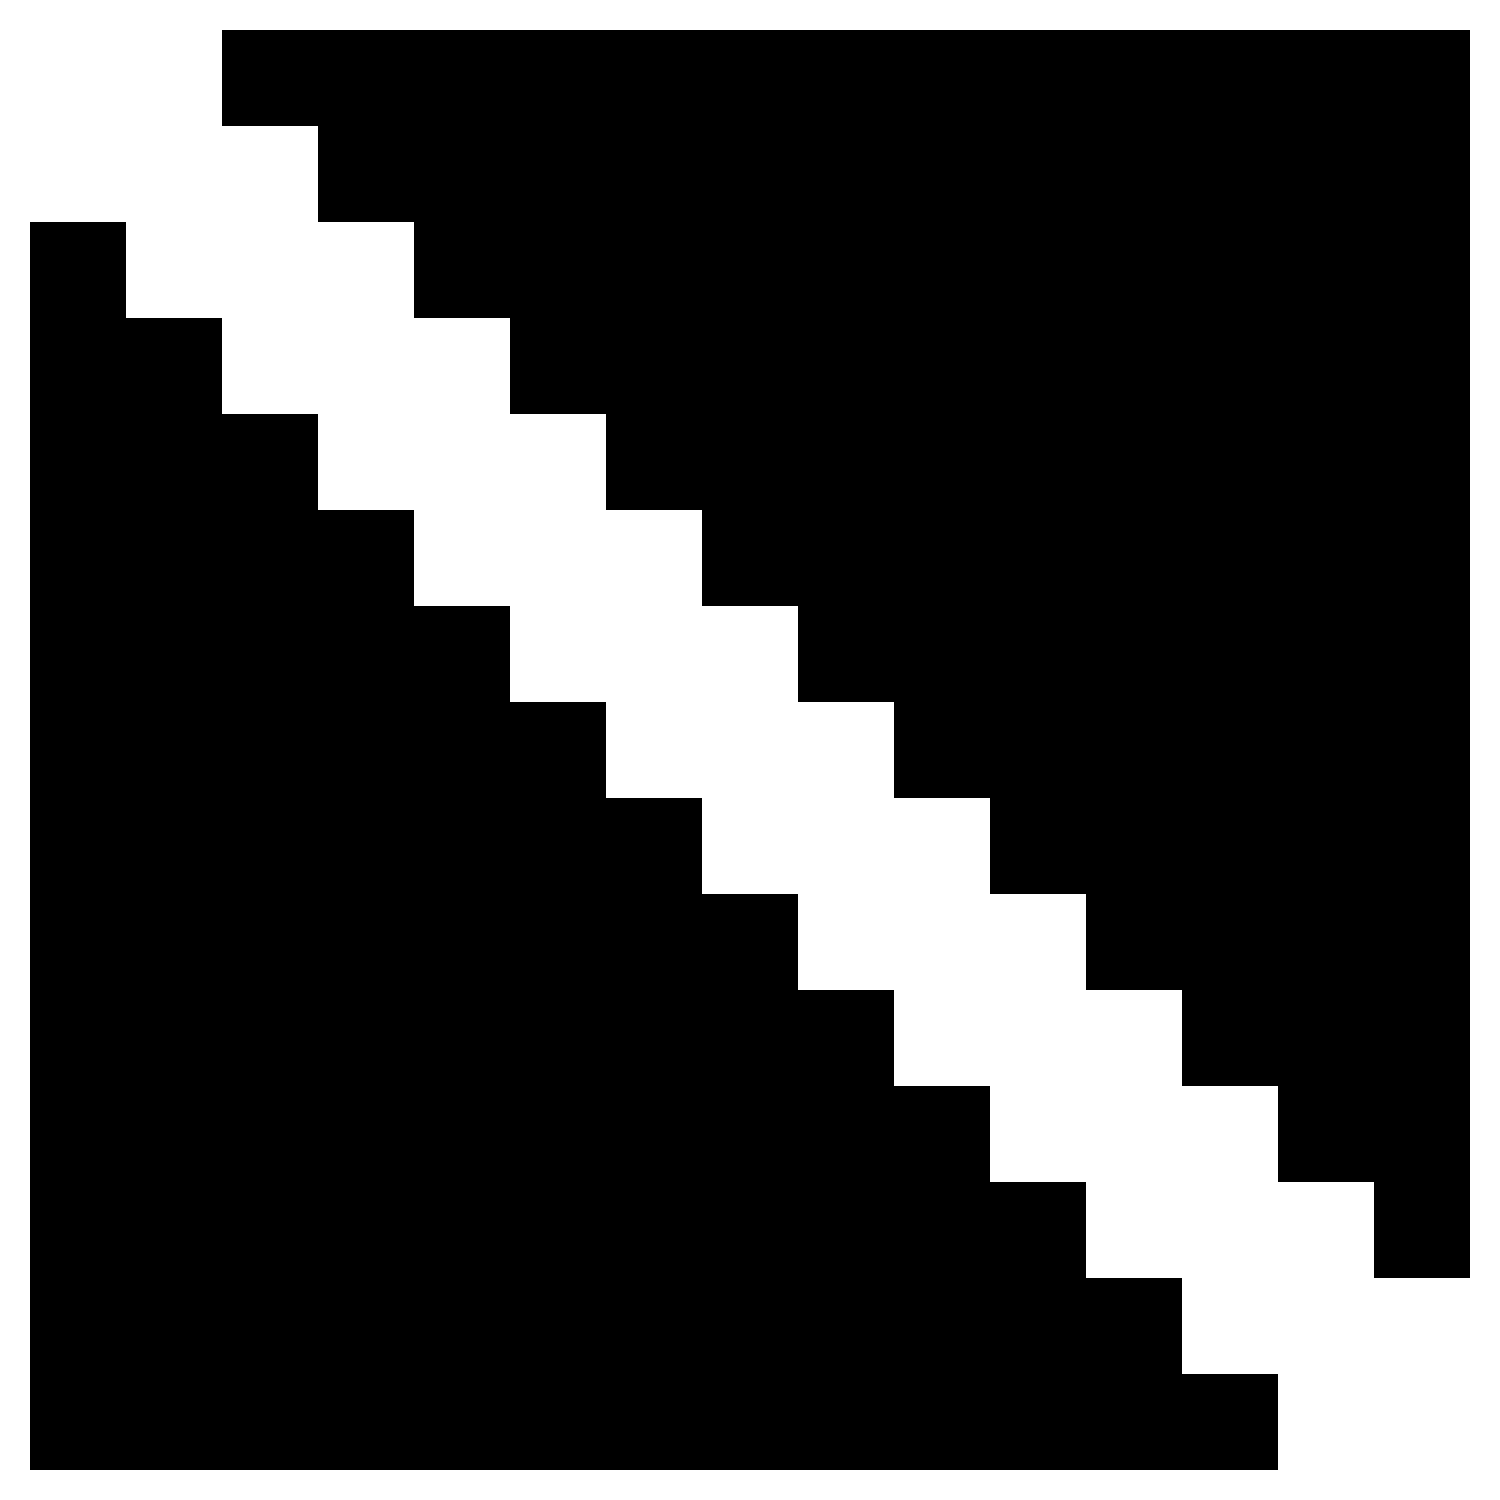

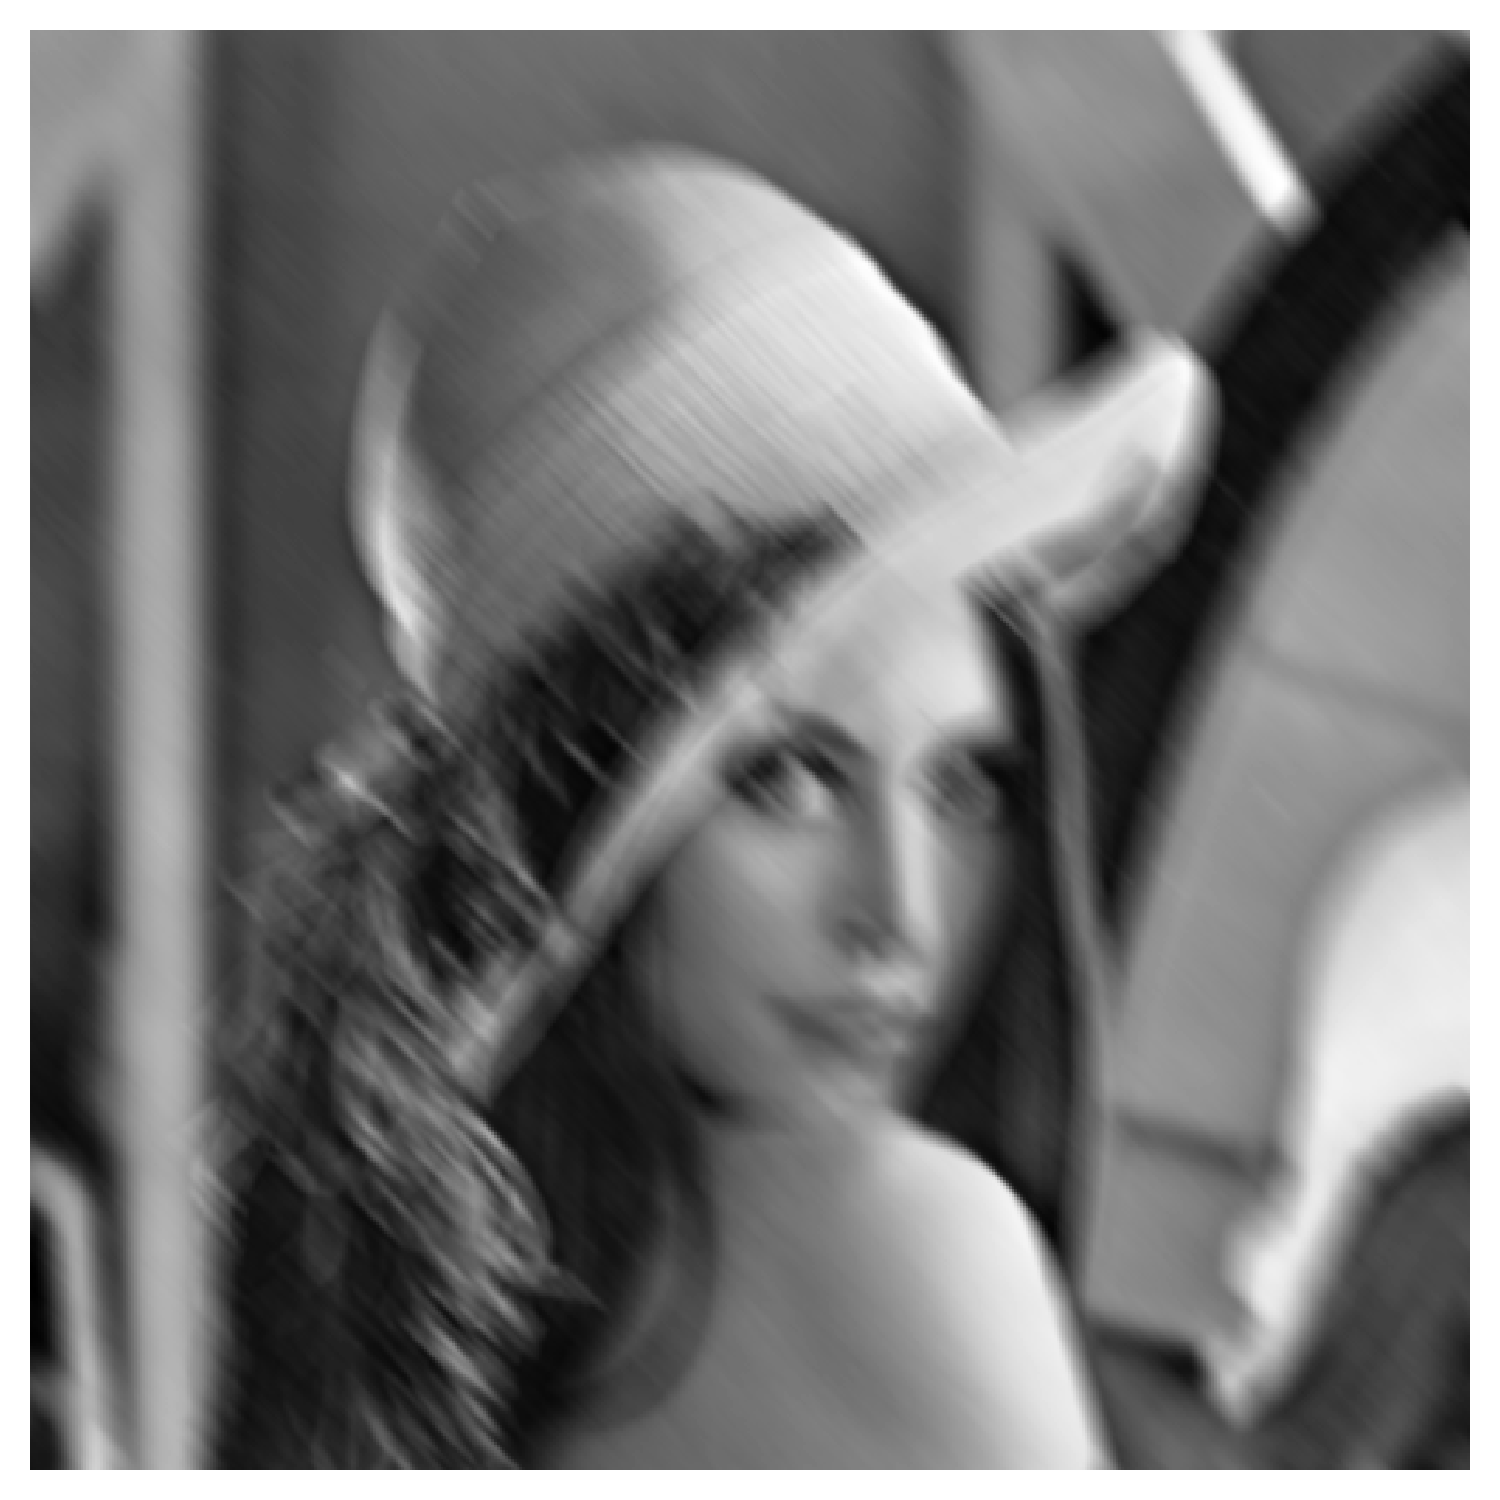

temps mon algo : 16.29 secondes
temps algo prof : 8.83 secondes


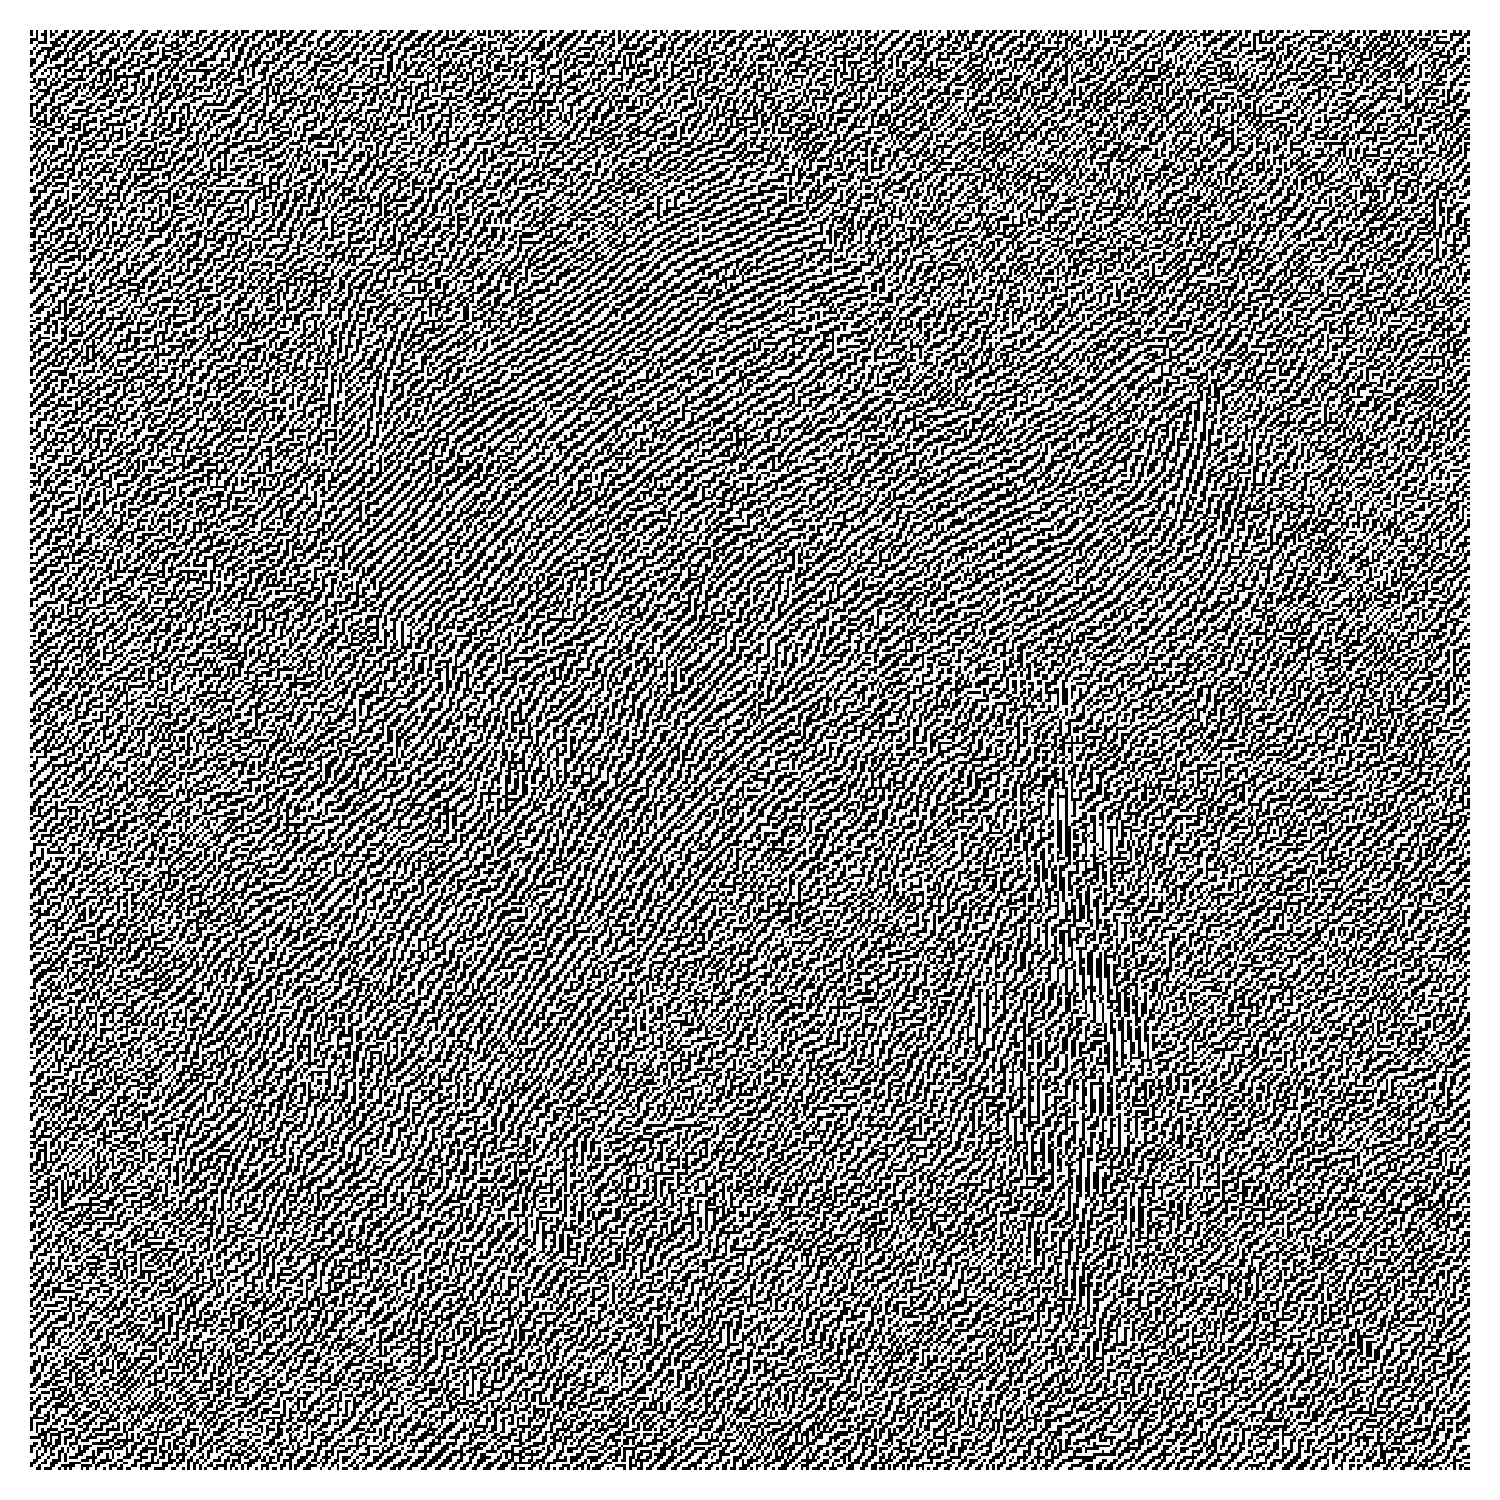

SNR1 = -1.90 dB


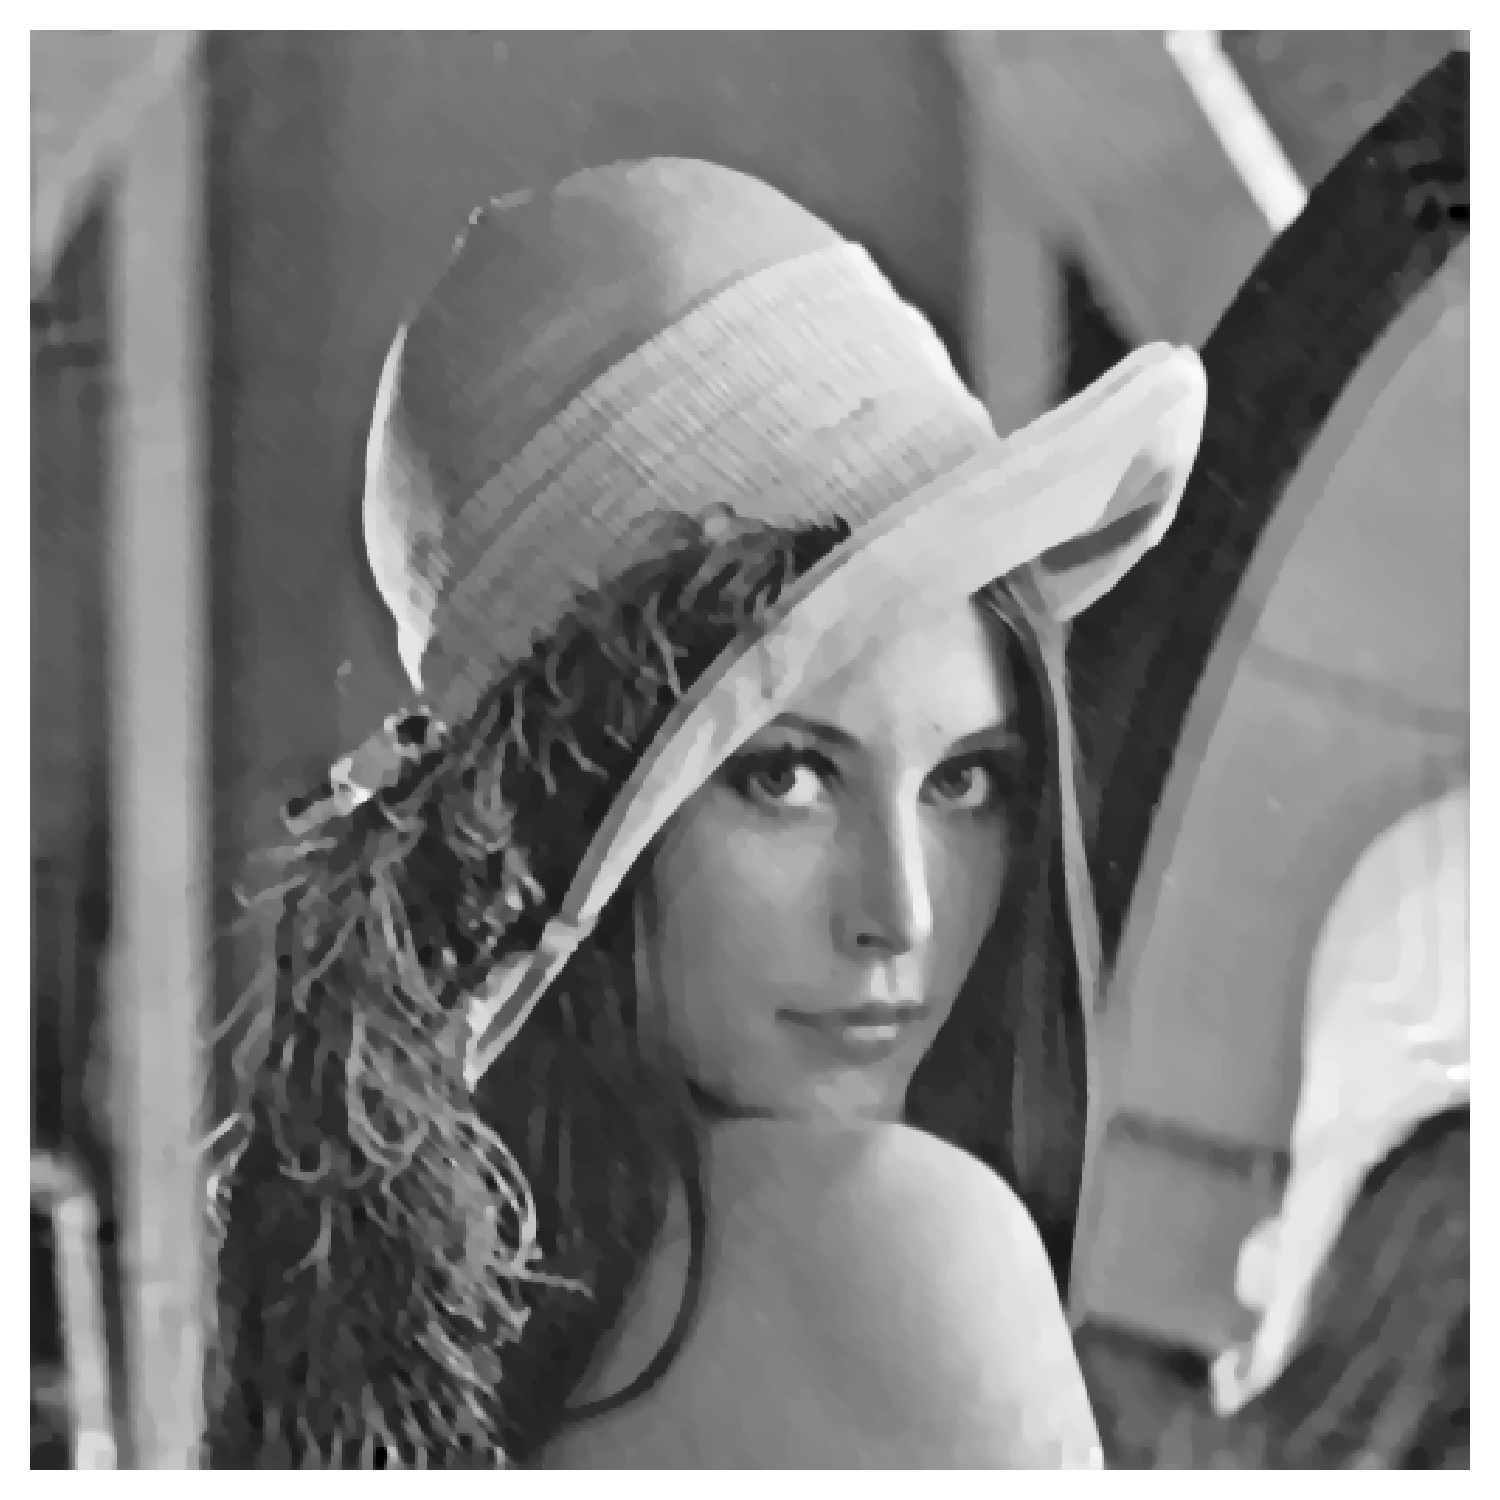

SNR2 = 23.11 dB


In [ ]:

def random_blur_kernel(size=9, sigma_range=(0.5, 3.0), seed=None):
    """
    Génère un noyau de flou aléatoire (gaussien anisotrope + normalisation).
    """
    if seed is not None:
        np.random.seed(seed)

    ax = np.arange(-(size//2), size//2 + 1)
    xx, yy = np.meshgrid(ax, ax)

    sigma_x = np.random.uniform(*sigma_range)
    sigma_y = np.random.uniform(*sigma_range)

    theta = np.random.uniform(0, np.pi)
    cos_t, sin_t = np.cos(theta), np.sin(theta)

    x_rot = cos_t * xx + sin_t * yy
    y_rot = -sin_t * xx + cos_t * yy

    kernel = np.exp(-(x_rot**2)/(2*sigma_x**2) - (y_rot**2)/(2*sigma_y**2))

    kernel /= np.sum(kernel)
    return kernel.astype(np.float32)


def add_gaussian_noise(img, sigma=0.01, seed=None, clip=True):
    """
    Ajoute un bruit gaussien additif à une image en niveaux de gris.
    """
    if seed is not None:
        np.random.seed(seed)
    noise = sigma * np.random.randn(*img.shape).astype(np.float32)
    noisy = img.astype(np.float32) + noise
    if clip:
        noisy = np.clip(noisy, 0.0, 1.0)
    return noisy


def snr(x, xhat):
    num = np.sum(x**2)
    den = np.sum((x - xhat)**2) + 1e-12
    return 10.0 * np.log10(num / den)


# Noyau de flou à la main
t=15
K=np.zeros((t,t))
Mh=4*t+1 #taille du spectre
for k in range(t):
    K[k,k]=1
    if k>0:
        K[k,k-1]=1
    if k<t-1:
        K[k,k+1]=1
K/=K.sum()


# Noyau identité pour vérifier le fenêtrage
ksize = 11
K1 = np.zeros((ksize, ksize), dtype=np.float32)
c = ksize // 2
K1[c, c] = 1.0


# im_sym = extend_sym(image)
# phi = random_blur_kernel(size=11, sigma_range=(1.0, 3.0), seed=42)
view_image(K, cmap='gray') 

f = convolve2d(image, K, mode='same',boundary='symm')
view_image(f)
start = time.perf_counter()
u_rec = tv_deconv(f, K, lam=2000, gamma=5, max_iters=100, clip=True)
end = time.perf_counter()


print(f"temps mon algo : {end - start:.2f} secondes")

start = time.perf_counter()
u_rec_2 = TVdeconv(f, K, lamb = 2000, gamma=5, edgehandle='taper')
end = time.perf_counter()

print(f"temps algo prof : {end - start:.2f} secondes")


# u_rec = inv_extend_sym(u_rec)
# u_rec_2 = inv_extend_sym(u_rec_2)
SNR1 = snr(image, u_rec)
SNR2 = snr(image, u_rec_2)
view_image(u_rec)
print(f"SNR1 = {SNR1:.2f} dB")
view_image(u_rec_2)
print(f"SNR2 = {SNR2:.2f} dB")





